In [1]:
import os
import sys 

%load_ext autoreload
import torch
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet
from sklearn.impute import SimpleImputer, KNNImputer
from torch.nn.functional import interpolate

from utils import *

%autoreload 2
sys.path.append('../AWLoss')
from networks import *
from losses import AWLoss
from datasets import MaskedUltrasoundDataset2D
from landscape import *


import matplotlib.pyplot as plt
import matplotlib.colors as clt
import progressbar
import random
import numpy as np

from saving import *

## CUDA Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)            

Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


# MRI Dataset 

In [3]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI-sagittal/")
size = 256
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(size),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x, "outer")),
                    Lambda(lambda x: scale2range(x, [0., 1.])),
                    ])

mask = create_mask((size,size), (0,3), (0,1))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=None)
print(ds, "\n")
print(ds.info(nsamples=30))


{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': None, 'transform': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'mode': 'mri', 'len': 553} 



/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'max': 1.0, 'min': 0.0, 'mean': 0.04609345644712448, 'std': 0.11560548841953278, 'shape': torch.Size([1, 256, 256])}


## Data split

In [4]:
valid_ratio = 0.2
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

443 110


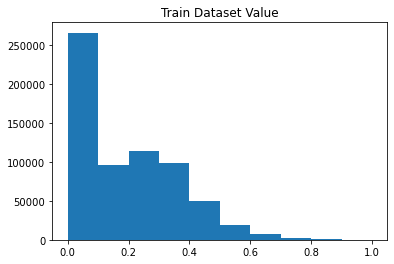

In [5]:
data = []
for i in range(min(len(trainds), 10)):
    data += list((trainds[i][1].flatten().detach().cpu().numpy()))
plt.title("Train Dataset Value")
plt.hist(data)
plt.show()

# Model 

In [6]:
def make_model(nc=64):
    set_seed(42)
    channels = (16, 32, 64)#, 128, 256)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=3,
    act="mish")
    model = nn.DataParallel(model) 
    return model.to(device)

# Train Function

In [7]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, 
                log_frequency=10, sample_input=None, sample_target=None, device="cpu", 
                exp_name="", save=True, scheduler=None):
                
    print("\n\nTraining started ...")
    try:
        all_train_losses, all_valid_losses = [], []
        with progressbar.ProgressBar(max_value=nepochs) as bar:    
            for epoch in range(nepochs):
                # Train and validate epoch
                train_loss = train(model, train_loader, optimizer, loss, scheduler, device)
                all_train_losses.append(train_loss.item())
                if valid_loader:
                    valid_loss = validate(model, valid_loader, loss, device)
                    all_valid_losses.append(valid_loss.item())
                
                bar.update(epoch)
                
                # Logging
                log = {"epoch": epoch, "train_loss": train_loss.item()}
                if valid_loader:
                    log.update({"valid_loss": valid_loss.item()})
                    
                if (epoch % log_frequency == 0 or epoch==nepochs-1):
                    print("\n", log)

                    if valid_loader:
                        model.eval()
                        X, target = next(iter(valid_loader))
                        X, target = X[:train_loader.batch_size], target[:train_loader.batch_size]
                        recon = torch.sigmoid(model(X))

                        fig, axs = plt.subplots(4, 1, figsize=(10*train_loader.batch_size, 15))
                        axs[0].imshow(make_grid(X, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data[0], cmap='Greys_r')
                        axs[1].imshow(make_grid(recon, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data[0], cmap='Greys_r')
                        axs[2].imshow(make_grid(target, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data[0], cmap='Greys_r')
                        try:
                            loss(X, target)
                            v = loss.filters
                        except:
                            v = torch.zeros_like(X)
                        axs[3].imshow(make_grid(v, pad_value=0, padding=2, vmin=-0.1, vmax=0.1).cpu().data[0], cmap='seismic')
                        plt.show()

                    if sample_input is not None:
                        idx = int(sample_input.shape[0]/2)
                        samples = {"Input idx %g"%idx: sample_input[idx]}

                        # Model forward pass
                        model.eval()
                        X = sample_input.unsqueeze(0).to(device)
                        # recon = torch.tanh(model(X))[0]
                        recon = torch.sigmoid(model(X))[0]
                        samples.update({"Reconstruction idx %g"%idx: recon[idx].cpu().detach().numpy()})

                        # If testing sample provided
                        if sample_target is not None:
                            samples.update({"Target idx %g"%idx: sample_target[idx]})

                            # Loss evaluation and filters
                            f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                try:
                                    loss_list = [str(l) for l in loss.losses]
                                    awloss = loss.losses[loss_list.index("AWLoss()")]
                                    v, T = awloss.filters[0], awloss.T
                                except:
                                    v, T = torch.tensor([0.]), torch.tensor([0.])
                            print(" argidx T, v: ",torch.argmin(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                
                    samples_fig = plot_samples(samples)
                    losses_fig = plot_losses(losses={"train": all_train_losses, "valid":all_valid_losses},
                                filters={"Weiner Filter": v.flatten().cpu().detach().numpy(), "Penalty": T.flatten().cpu().detach().numpy()})
        raise(KeyboardInterrupt)
    except KeyboardInterrupt:                                   
        if save:
            objs = { "mask": train_loader.dataset.dataset.mask,
                "train_loader":train_loader,
                "valid_loader":valid_loader,
                "x_sample": x_sample,
                "y_sample": y_sample,
                "recon": recon,

                "model": model,
                "optim": optimizer,
                "loss": loss,
                "train_losses": all_train_losses,
                "vald_losses": all_valid_losses,
                "penalty": T,
                }

            summary = { "data_mode": train_loader.dataset.dataset.mode,
                        "interpolation_model": "UNet",
                        "loss": str(loss),
                        "img_size": x_sample.numpy().shape,
                        "device":device,
                        "nepochs": nepochs,
                        "current_epoch":epoch, 
                        "learning_rate":optimizer.defaults["lr"],
                        "batch_size":train_loader.batch_size,
                        "ntrain": len(train_loader.dataset),}
            try:
                summary["nvalid"]= len(valid_loader.dataset)
            except:
                summary["nvalid"]= 0
            try:
                summary["aw_filter_dim"] = loss.filter_dim,
                summary["aw_epsilon"] =  loss.epsilon,
                summary["aw_gamma"] =  loss.gamma,
                summary["aw_eta"] =  loss.eta,
                summary[ "aw_std"] = loss.std
            except:
                summary["aw_filter_dim"] = None
                summary["aw_epsilon"] =  None
                summary[ "aw_std"] = None

            figs = {"losses":losses_fig, "samples":samples_fig}
            save_exp(objs=objs, figs=figs, summary=summary, overwrite=False)            
    return None
            

# Training Setup

In [8]:
# Set training static parameters and hyperparameters
nepochs=300                        
learning_rate=1e-2
batch_size=32                                        

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = DataLoader(validds,
                        batch_size=1000,
                        shuffle=False,
                        num_workers=4)


# Sample for visualisation
x_sample, y_sample = validds[0]
f = (nepochs//2) + 1

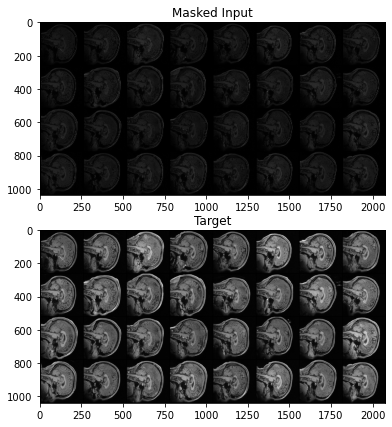

In [9]:
train_batch = next(iter(train_loader))
fig, axs = plt.subplots(2, 1, figsize=(4*batch_size,7))
axs[0].imshow(make_grid(train_batch[0], pad_value=0, padding=3).data[0], cmap='Greys_r')
axs[0].set_title("Masked Input")
axs[1].imshow(make_grid(train_batch[1], pad_value=0, padding=3).data[0], cmap='Greys_r')
axs[1].set_title("Target")
plt.show()

# Train AWLoss

In [10]:
def laplacian2D(mesh):
    alpha, beta = -0.2, 1.5
    xx, yy = mesh[:,:,0], mesh[:,:,1]
    x = torch.sqrt(xx**2 + yy**2) 
    T = 1 - torch.exp(-torch.abs(x) ** alpha) ** beta
    T = scale2range(T, [0.05, 1.])
    return T

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")




Training started ...


[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.4136790633201599, 'valid_loss': 0.24272078275680542}


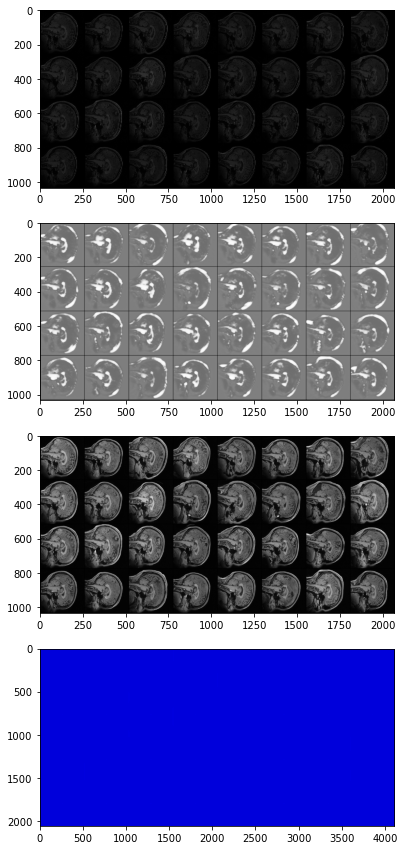

 argidx T, v:  0 130560


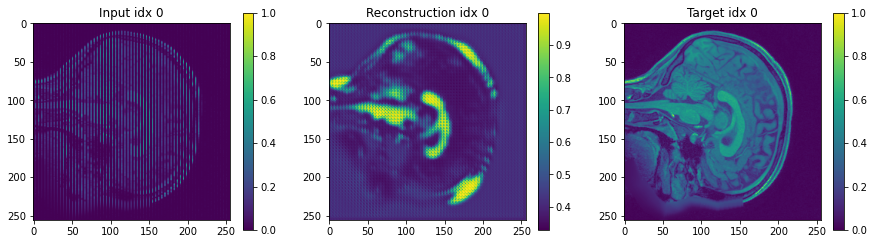

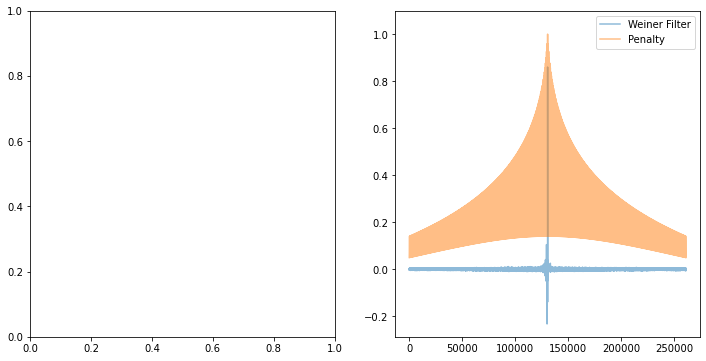

 33% (100 of 300) |#######               | Elapsed Time: 0:08:34 ETA:   0:17:34


 {'epoch': 100, 'train_loss': 0.0785524770617485, 'valid_loss': 0.07855982333421707}


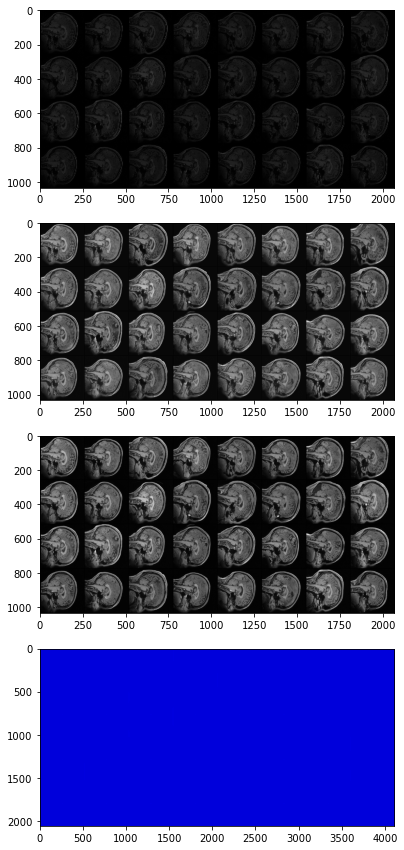

 argidx T, v:  0 130560


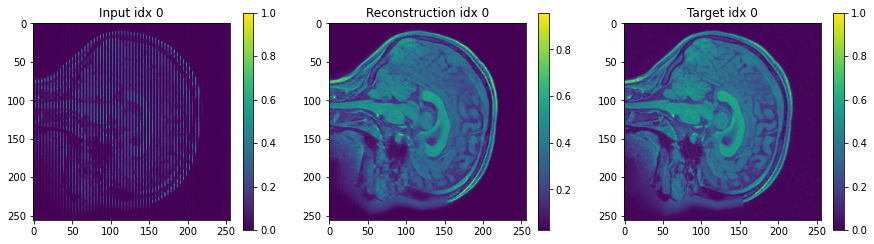

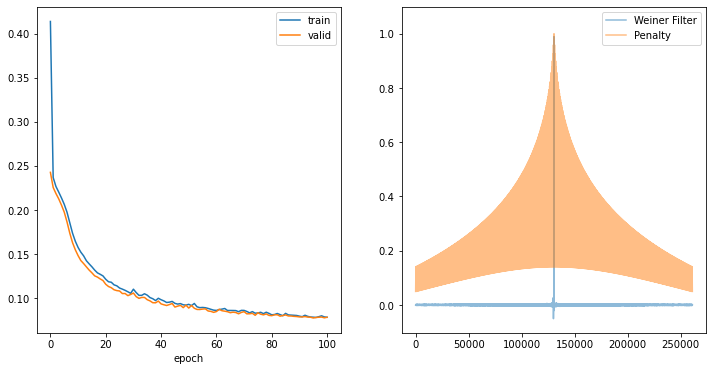

 66% (200 of 300) |##############        | Elapsed Time: 0:17:11 ETA:   0:08:17


 {'epoch': 200, 'train_loss': 0.06864257901906967, 'valid_loss': 0.07288546860218048}


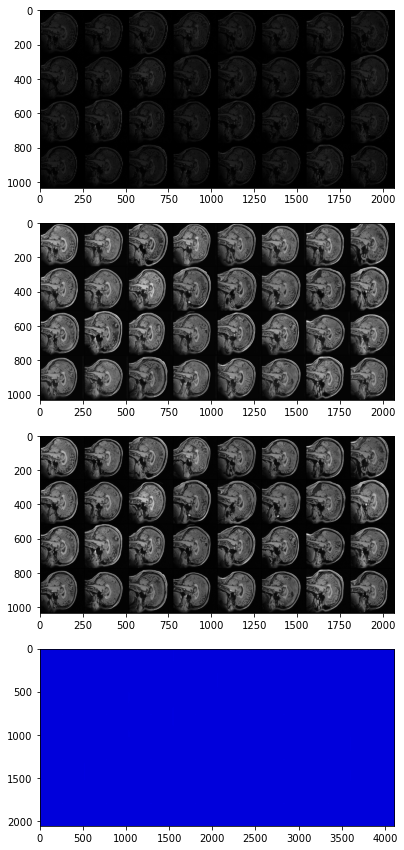

 argidx T, v:  0 130560


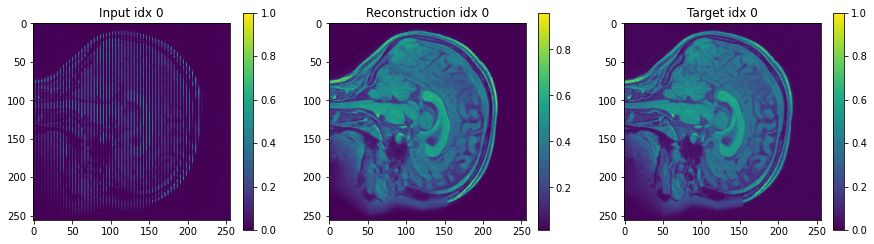

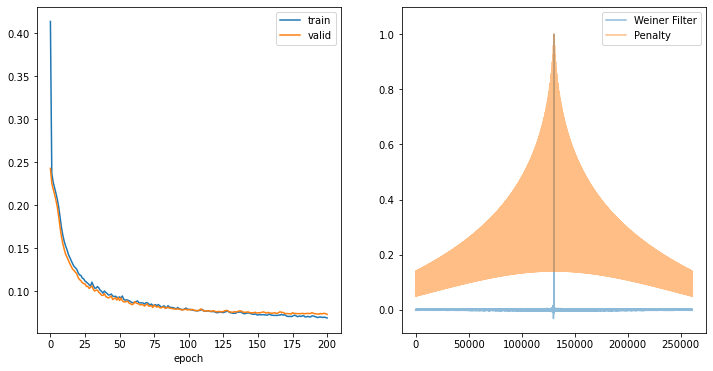

 99% (299 of 300) |##################### | Elapsed Time: 0:25:46 ETA:   0:00:05


 {'epoch': 299, 'train_loss': 0.06423334032297134, 'valid_loss': 0.07216491550207138}


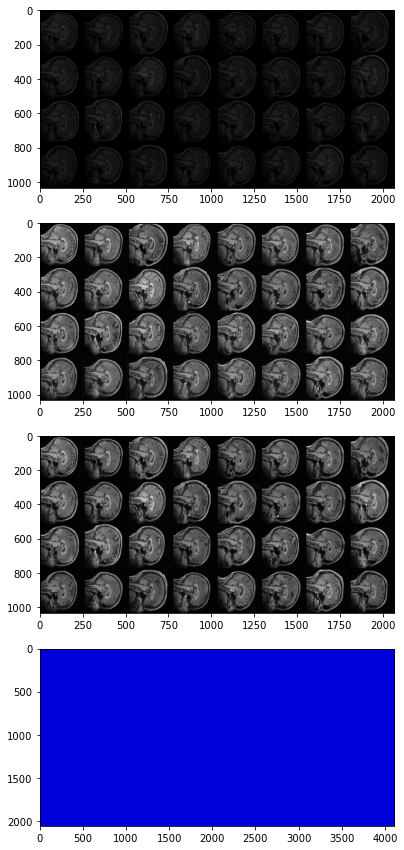

 argidx T, v:  0 130560


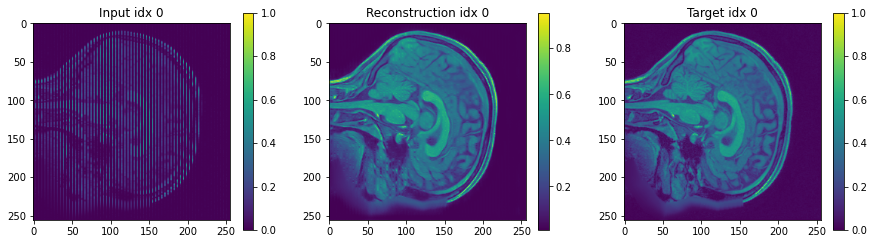

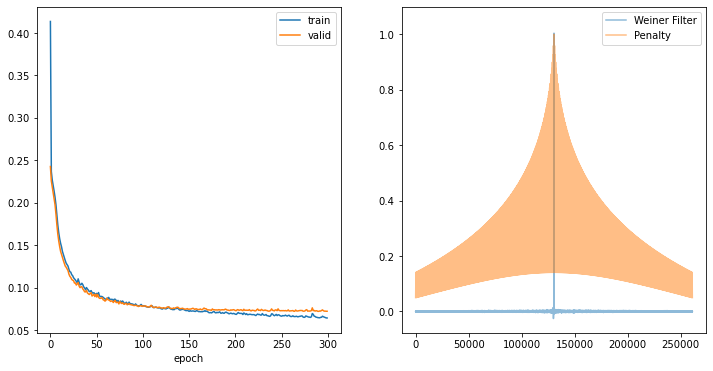

100% (300 of 300) |######################| Elapsed Time: 0:25:51 Time:  0:25:51


Saving experiment at /home/dp4018/scripts/lsrcodes/exp91 ...
	 exp91/mask.pkl
	 exp91/train_loader.pkl
	 exp91/valid_loader.pkl
	 exp91/x_sample.pkl
	 exp91/y_sample.pkl
	 exp91/recon.pkl
	 exp91/model.pkl
	 exp91/optim.pkl
	 exp91/loss.pkl
	 exp91/train_losses.pkl
	 exp91/vald_losses.pkl
	 exp91/penalty.pkl
	 exp91/losses.png
	 exp91/samples.png
	 summary.json


In [11]:
awmodel = make_model(nc=x_sample.shape[0])
awoptim = torch.optim.Adam(awmodel.parameters(), lr=learning_rate)

awloss     = AWLoss(filter_dim=2, method="fft", std=3e-7, reduction="mean", store_filters="unorm", 
                    epsilon=250., gamma=1e-9, eta=0., filter_scale=2, penalty_function=laplacian2D)


train_model(awmodel, awoptim, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=100, 
            sample_input=x_sample, sample_target=y_sample, device=device, save=True)




# Train MSE Loss



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.08045421540737152, 'valid_loss': 0.06569705158472061}


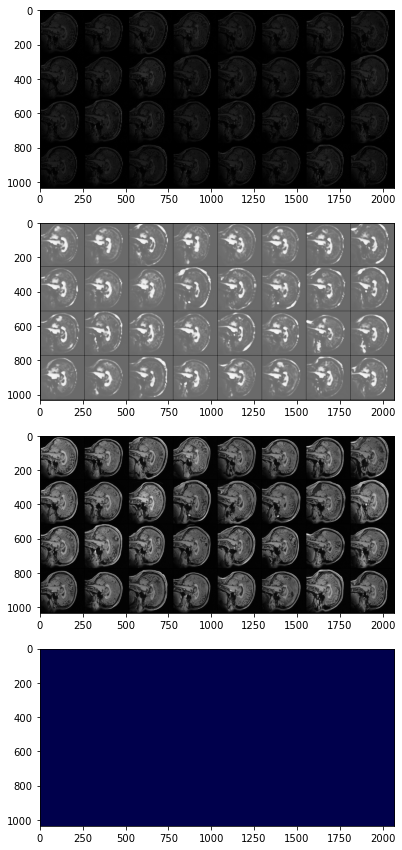

 argidx T, v:  0 0


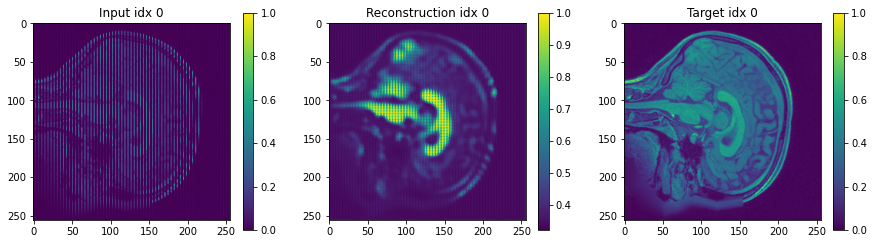

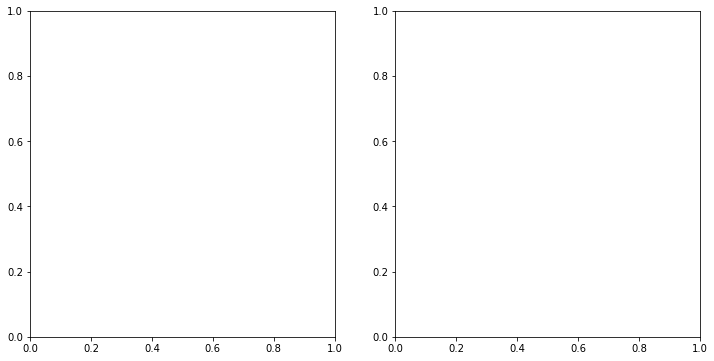

 33% (100 of 300) |#######               | Elapsed Time: 0:06:58 ETA:   0:14:00


 {'epoch': 100, 'train_loss': 0.002691222820430994, 'valid_loss': 0.0026318267919123173}


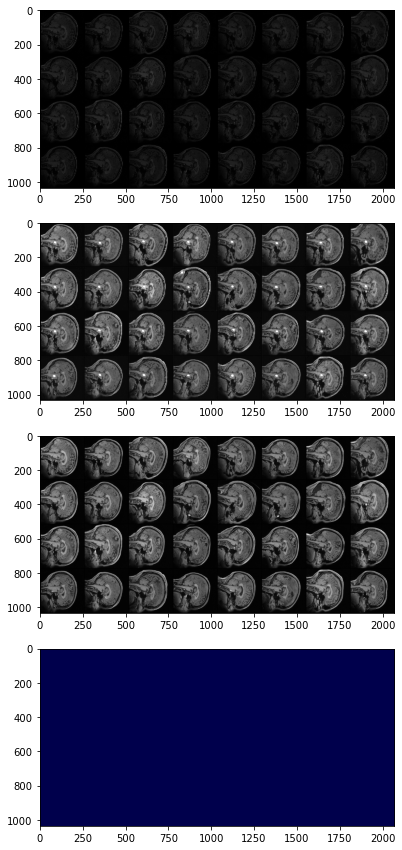

 argidx T, v:  0 0


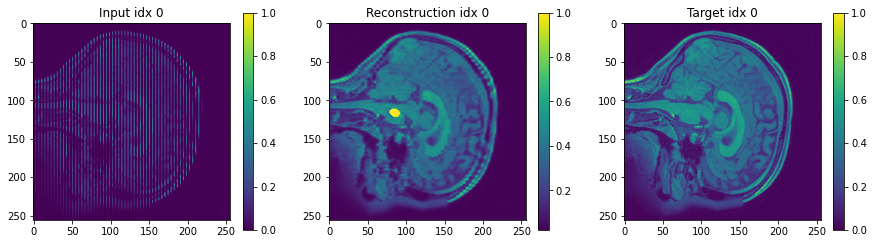

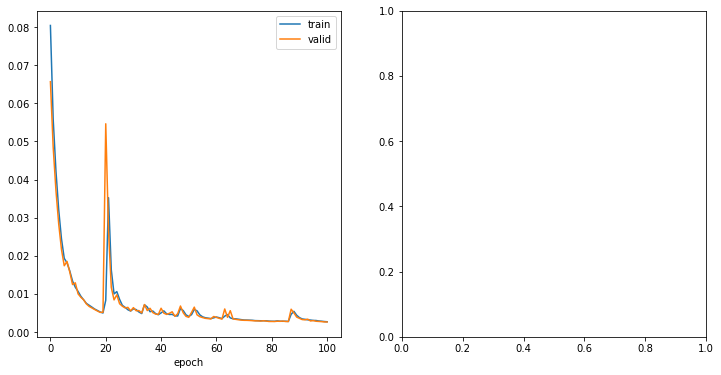

 66% (200 of 300) |##############        | Elapsed Time: 0:13:52 ETA:   0:07:24


 {'epoch': 200, 'train_loss': 0.0018352186307311058, 'valid_loss': 0.0017420223448425531}


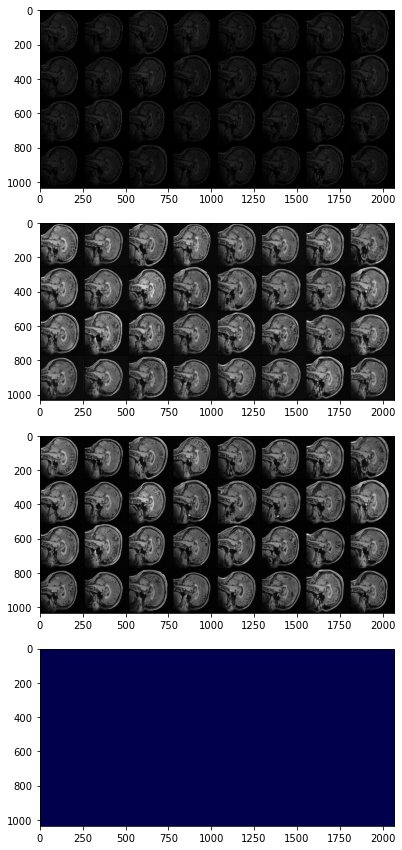

 argidx T, v:  0 0


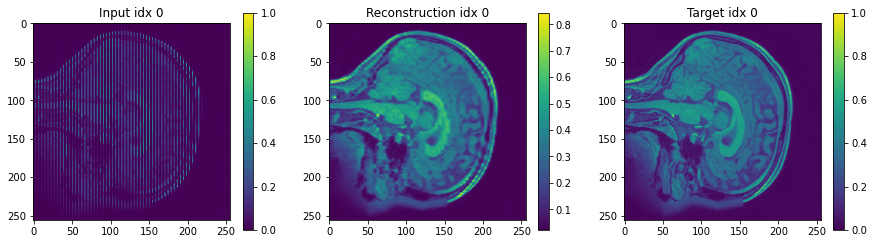

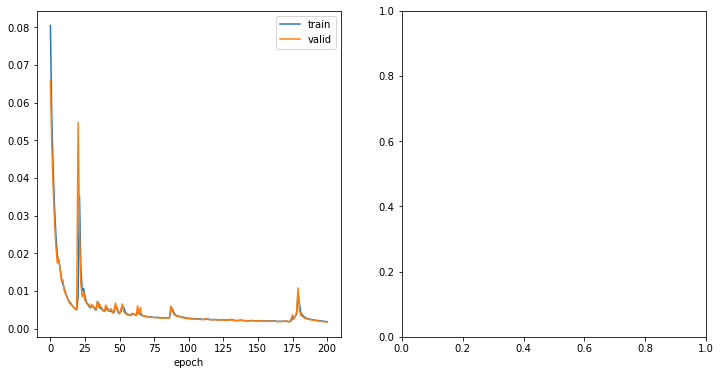

 99% (299 of 300) |##################### | Elapsed Time: 0:20:51 ETA:   0:00:04


 {'epoch': 299, 'train_loss': 0.0012488404754549265, 'valid_loss': 0.0012015189277008176}


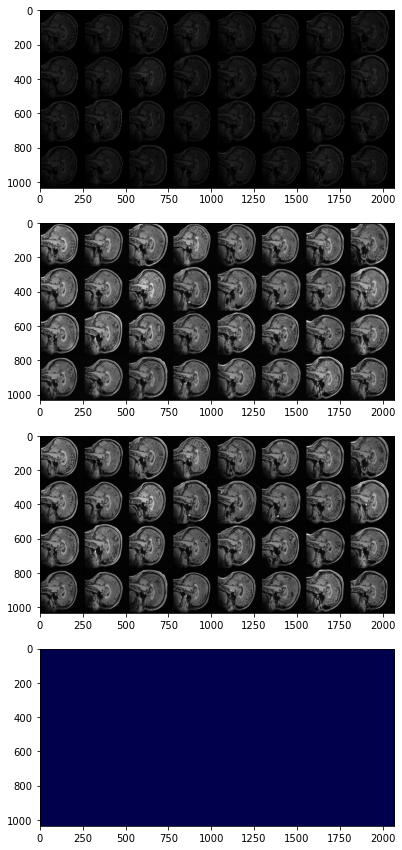

 argidx T, v:  0 0


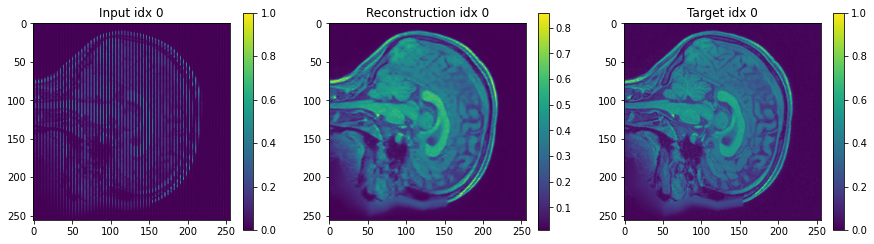

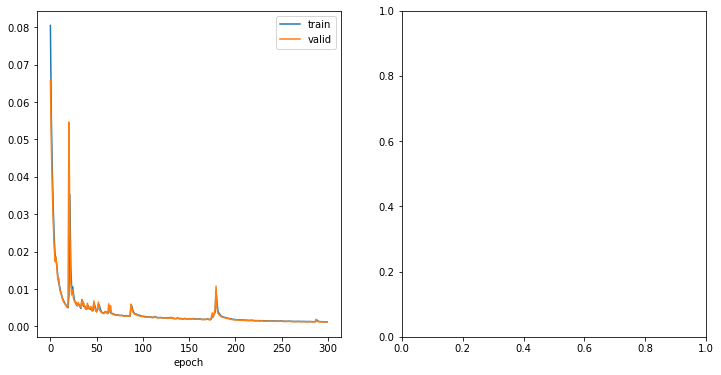

100% (300 of 300) |######################| Elapsed Time: 0:20:54 Time:  0:20:54


Saving experiment at /home/dp4018/scripts/lsrcodes/exp90 ...
	 exp90/mask.pkl
	 exp90/train_loader.pkl
	 exp90/valid_loader.pkl
	 exp90/x_sample.pkl
	 exp90/y_sample.pkl
	 exp90/recon.pkl
	 exp90/model.pkl
	 exp90/optim.pkl
	 exp90/loss.pkl
	 exp90/train_losses.pkl
	 exp90/vald_losses.pkl
	 exp90/penalty.pkl
	 exp90/losses.png
	 exp90/samples.png
	 summary.json


In [13]:
msemodel = make_model(nc=x_sample.shape[0])
mseoptim = torch.optim.Adam(msemodel.parameters(), lr=learning_rate)

mseloss     = nn.MSELoss(reduction="mean")

train_model(msemodel, mseoptim, mseloss, train_loader,  valid_loader=valid_loader, nepochs=nepochs, log_frequency=100, 
            sample_input=x_sample, sample_target=y_sample, device=device, save=True)

# Train AWLoss + MSE

In [14]:
from math import log, floor
class JointLoss(nn.Module):
    def __init__(self, losses, weights, norm=False):
        super(JointLoss, self).__init__()
        self.losses = losses
        self.weights = weights
        self.norm = norm

    def __str__(self):
        name = ""
        for l , w in zip(self.losses, self.weights):
            name += "{}(w={:.1E}) ".format(str(l)[:-2], w)
        return name[:-1]

    def scale(self, x):
        if self.norm:
            return x / 10**floor(log(x, 10))
        else:
            return x

    def forward(self, x, y):
        total_loss = 0.
        for l, w in zip(self.losses, self.weights):
            total_loss += w * self.scale(l(x, y))
        return total_loss

In [15]:
# awloss     = AWLoss(filter_dim=2, method="fft", std=3e-4, reduction="mean", store_filters="norm", 
#                     epsilon=10., gamma=1e-9, eta=0., filter_scale=2)
# mseloss     = nn.MSELoss(reduction="mean")                

# combmodel = make_model(nc=x_sample.shape[0])
# comboptim = torch.optim.Adam(combmodel.parameters(), lr=learning_rate)
# combloss    = JointLoss((awloss, mseloss), (1., 1.))

# train_model(combmodel, comboptim, combloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, 
# log_frequency=100, sample_input=x_sample, sample_target=y_sample, device=device, save=True)

## Interpolation

In [16]:
# interp_mode = "bicubic"
# X = x_sample[0].numpy()
# model = KNNImputer(missing_values=0.)
# X_ = model.fit_transform(X)
# X_ = torch.tensor(X_).unsqueeze(0).unsqueeze(0)
# recon = interpolate(X_, X.shape, mode=interp_mode)[0]

# print(x_sample.shape, y_sample.shape, recon.shape)

# idx = int(x_sample.shape[0]/2)
# samples = { "Input idx %g"%idx: x_sample[idx],
#             "Reconstruction idx %g"%idx: recon[idx].cpu().detach().numpy(),
#             "Target idx %g"%idx: y_sample[idx]}
# samples_fig = plot_samples(samples, vmin=-1., vmax=1.)

# objs = { "mask": train_loader.dataset.dataset.mask,
#     "train_loader":None,
#     "valid_loader":None,
#     "x_sample": x_sample,
#     "y_sample": y_sample,
#     "recon": recon,

#     "model": None,
#     "optim": None,
#     "loss": None,
#     }

# summary = { "data_mode": train_loader.dataset.dataset.mode,
#             "interpolation_model": interp_mode,
#             "loss": None,
#             "img_size": x_sample.numpy().shape,
#             "device":"cpu",
#             "nepochs": None,
#             "current_epoch":None,
#             "learning_rate":None,
#             "batch_size":None,
#             "ntrain": None,
#             "nvalid": None,
#             "aw_filter_dim": None,
#             "aw_epsilon": None,
#             "aw_std": None}

# figs = {"samples":samples_fig}
# save_exp(objs=objs, figs=figs, summary=summary, overwrite=False)  


: 